# This assignment provides hands-on data wrangling and classification experience
For this assignment, you are a Machine Learning Engineer at a local bank, and your task is to analyze whether loan applicants qualify, based on their personal information.
Tasks are:
1. Data wrangling to perform one-hot-encoding for the data and normalization
1. Eliminating unimportant features
1. Performing classification to predict qualification for loan in future.

### Import the necessary modules

In [1]:
import os
import tensorflow as tf
#from tensorflow.contrib.tensorboard.plugins import projector
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

### Load the training data. Print out its shape and first few rows.

In [2]:
url = "https://raw.githubusercontent.com/FourthBrain/2.-Classification/main/bank-full.csv?token=ARJV76TWTYENKFZKXB4CUYS7SIDOM"
df_train = pd.read_csv(url, sep=';')
print(np.shape(df_train))
df_train.head()

(45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Exercise: Perform Exploratory Data Analysis on each feature

In [21]:
### START CODE HERE ###
# Get the info (column number and name, non-null count, and dtype) for each column in the training df
train_info = pd.DataFrame()
train_info['name'] = df_train.columns
train_info['non_null_count'] = df_train.notna().sum().values
train_info['dtype'] = df_train.dtypes.values
print(train_info)
# Get summary statistics for the training df with the describe() method
df_train.describe()
### END CODE HERE ###

         name  non_null_count   dtype
0         age           45211   int64
1         job           45211  object
2     marital           45211  object
3   education           45211  object
4     default           45211  object
5     balance           45211   int64
6     housing           45211  object
7        loan           45211  object
8     contact           45211  object
9         day           45211   int64
10      month           45211  object
11   duration           45211   int64
12   campaign           45211   int64
13      pdays           45211   int64
14   previous           45211   int64
15   poutcome           45211  object
16          y           45211  object


,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


### Exercise: Visualize the distributions of each numeric feature

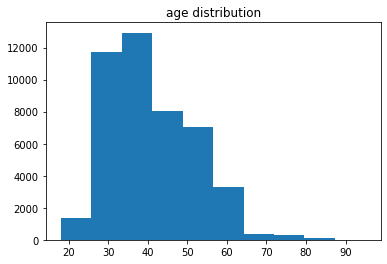

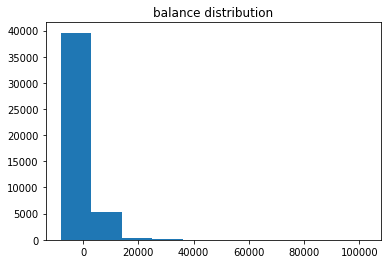

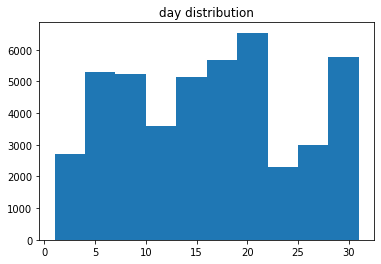

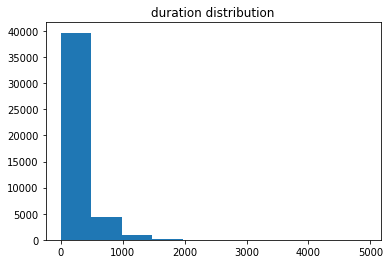

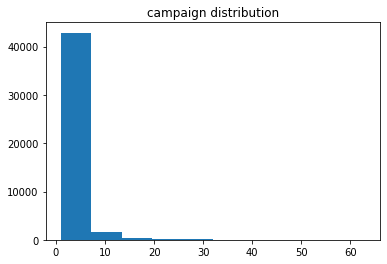

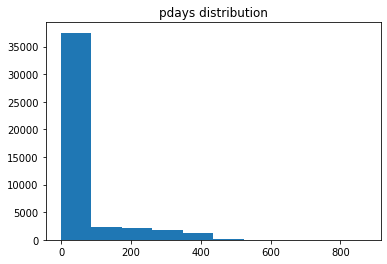

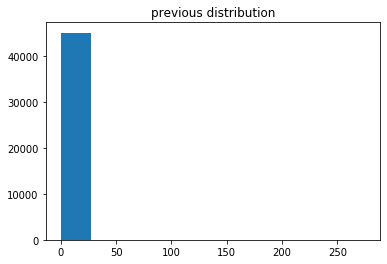

In [30]:
### START CODE HERE ###
# Use a list comprehension to extract the names of the numeric columns of the training df 
# (those with an integer dtype)
numeric_columns = train_info.iloc[train_info.dtype[train_info.dtype == np.int64].index].name.values.tolist()
# Loop through the numeric columns
for col in numeric_columns:
    # Generate a histogram of the current numeric feature column
    plt.hist(df_train[col])
    plt.title(f'{col} distribution')
    plt.show()
### END CODE HERE ###

### Exercise: Inspect the unique values of the non-numeric columns, and their counts

In [46]:
### START CODE HERE ###
# Use a list comprehension to list the names of the non-numeric columns in the training df
# (those with an object dtype)
non_numeric_columns = train_info.iloc[train_info.dtype[train_info.dtype != np.int64].index].name.values.tolist()
# Loop through the non-numeric columns
for col in non_numeric_columns:
    # Print the counts of each unique value in the current column
    print(col, '\n', df_train[col].value_counts(), '\n')
### END CODE HERE ###

job 
 blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64 

marital 
 married     27214
single      12790
divorced     5207
Name: marital, dtype: int64 

education 
 secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64 

default 
 no     44396
yes      815
Name: default, dtype: int64 

housing 
 yes    25130
no     20081
Name: housing, dtype: int64 

loan 
 no     37967
yes     7244
Name: loan, dtype: int64 

contact 
 cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64 

month 
 may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64 

poutcome 

### Exercise: Some columns are 'yes'/'no' binaries. Map them to integer binaries.

In [50]:
### START CODE HERE ###
# Make a list of the binary columns. There should be 4 of them. 
# Find their names in the output of the previous exercise.
binary_columns = df_train.nunique()[df_train.nunique() == 2].index.tolist()
assert len(binary_columns) == 4

# Create a dictionary in which the keys map to the values
# Remember, we want to replace 'no' and 'yes' with the appropriate integers
binary_mapping = {
    "no": 0,
    "yes": 1,
}

# Map the binary columns
for col in binary_columns:
    # Apply the mapping to the current column with the map() method for Pandas Series
    df_train[col] = df_train[col].map(binary_mapping)
### END CODE HERE ###

### Exericse: Map the months from strings to integers, with 1 corresponding to January, etc.

In [57]:
df_train.month.unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr', 'sep'], dtype=object)

In [58]:
### START CODE HERE ###
# Create the mapping dictionary
# Make sure the months' names are formatted properly
month_mapping = {
    'jan': 1, 
    'feb': 2, 
    'mar': 3, 
    'apr': 4, 
    'may': 5, 
    'jun': 6, 
    'jul': 7, 
    'aug': 8, 
    'sep': 9, 
    'oct': 10, 
    'nov': 11, 
    'dec': 12, 
}
# Map the months
df_train['month'] = df_train.month.map(month_mapping)
### END CODE HERE ###

### Exercise: One-hot encode the remaining categorical features

In [74]:
### START CODE HERE ###
# List the categorical features. There should be 5 of them.
categorical_columns = df_train.dtypes[df_train.dtypes != np.int64].index.tolist()
assert len(categorical_columns) == 5

# One-hot encode the categorical features with the get_dummies() function for Pandas DataFrames
df_train = pd.get_dummies(df_train, columns=categorical_columns, drop_first=True)
### E3ND CODE HERE ###

### Inspect the first few rows of our preprocessed DataFrame

In [75]:
df_train.head()

,age,default,balance,housing,loan,day,month,duration,campaign,pdays,...,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,58,0,2143,1,0,5,5,261,1,-1,...,1,0,0,1,0,0,1,0,0,1
1,44,0,29,1,0,5,5,151,1,-1,...,0,1,1,0,0,0,1,0,0,1
2,33,0,2,1,1,5,5,76,1,-1,...,1,0,1,0,0,0,1,0,0,1
3,47,0,1506,1,0,5,5,92,1,-1,...,1,0,0,0,1,0,1,0,0,1
4,33,0,1,0,0,5,5,198,1,-1,...,0,1,0,0,1,0,1,0,0,1


### Exercise: Extract the target values from the training DataFrame

In [77]:
### START CODE HERE ###
# Extract the target values from the training DataFrame
y = df_train.y
# Drop the target column from the training DataFrame
df_train = df_train.drop(columns='y')
### END CODE HERE ###

### Exercise: Inspect how balanced y is

For a balanced binary target, approximately half of its entries will be 1

In [79]:
### START CODE HERE ###
# Compute the fraction of positive values in the target
y.value_counts(normalize=True)
### END CODE HERE ###

0    0.883015
1    0.116985
Name: y, dtype: float64

### Print the current number of features

In [80]:
print(f'The training df currently has {df_train.shape[1]} features')

The training df currently has 32 features


### Exercise: Visually inspect the Pearson Correlations of each feature

Pandas provides the `corr()` method for DataFrames for this purpose

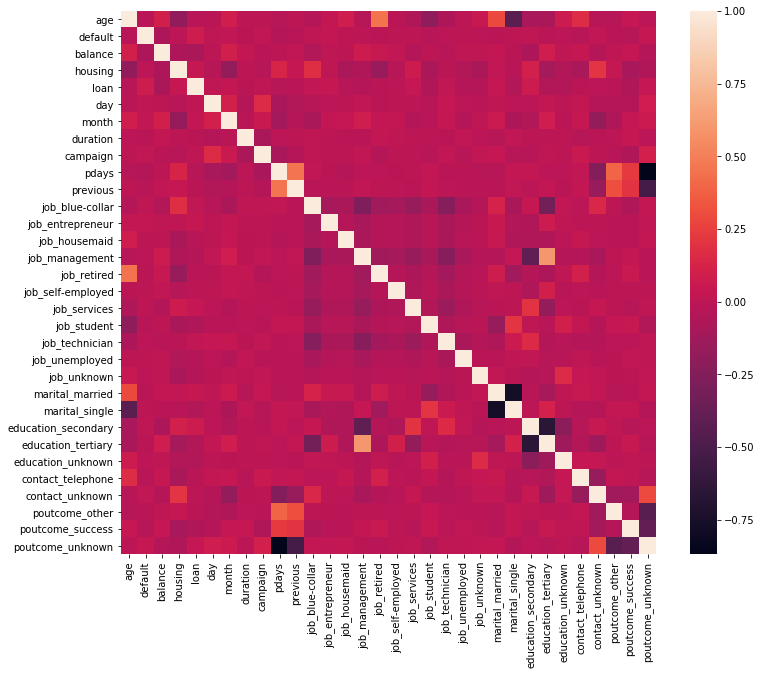

In [81]:
plt.figure(figsize=(12,10))
### START CODE HERE ###
# Compute the Pearson Correlation of each feature in the training df
cor = df_train.corr()
### END CODE HERE ###
# Plot the correlations
sns.heatmap(cor)
plt.show()
# Some intersting correlations pop up that need further analysis (later)
# we need to eliminate features that have very high absolute correlations

## Feature Selection

### Exercise: Drop feature columns which have a high absolute Pearson Correlation

Let's choose to drop the higher-indexed of the two correlated columns, i.e. the one that appears farther to the right in the df

In [83]:
cor

,age,default,balance,housing,loan,day,month,duration,campaign,pdays,...,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
age,1.000000,-0.017879,0.097783,-0.185513,-0.015655,-0.009120,0.092903,-0.004648,0.004760,-0.023758,...,0.286257,-0.427817,-0.093979,-0.081629,0.069665,0.170349,-0.020132,-0.022967,0.035526,-0.000816
default,-0.017879,1.000000,-0.066745,-0.006025,0.077234,0.009424,0.014989,-0.010021,0.016822,-0.029979,...,-0.014460,0.003115,0.013220,-0.015239,-0.001236,-0.017208,0.019933,-0.014445,-0.023344,0.039490
balance,0.097783,-0.066745,1.000000,-0.068768,-0.084350,0.004503,0.094605,0.021560,-0.014578,0.003435,...,0.025708,-0.012537,-0.069937,0.084001,0.011181,0.037999,-0.037331,0.008466,0.035240,-0.030271
housing,-0.185513,-0.006025,-0.068768,1.000000,0.041323,-0.027982,-0.173887,0.005075,-0.023599,0.124178,...,0.017681,-0.020475,0.101659,-0.099175,-0.047595,-0.080822,0.208409,0.039710,-0.091360,-0.063755
loan,-0.015655,0.077234,-0.084350,0.041323,1.000000,0.011370,0.021638,-0.012412,0.009980,-0.022754,...,0.036906,-0.051716,0.070625,-0.045940,-0.049992,-0.013183,-0.007211,-0.009099,-0.053713,0.031406
day,-0.009120,0.009424,0.004503,-0.027982,0.011370,1.000000,0.101989,-0.030206,0.162490,-0.093044,...,0.007102,-0.007412,-0.005831,0.021730,0.000114,0.023652,-0.034103,-0.032952,-0.030321,0.086256
month,0.092903,0.014989,0.094605,-0.173887,0.021638,0.101989,1.000000,-0.011866,0.054868,-0.108940,...,0.062925,-0.068586,-0.049881,0.082121,-0.015071,0.037628,-0.182490,-0.062626,0.033700,0.061391
duration,-0.004648,-0.010021,0.021560,0.005075,-0.012412,-0.030206,-0.011866,1.000000,-0.084570,-0.001565,...,-0.022683,0.020328,0.002084,0.000891,-0.000682,-0.023201,-0.014379,-0.001958,0.042389,-0.003491
campaign,0.004760,0.016822,-0.014578,-0.023599,0.009980,0.162490,0.054868,-0.084570,1.000000,-0.088628,...,0.031371,-0.023120,-0.020893,0.012866,0.005704,0.053895,0.004853,-0.020107,-0.057486,0.107965
pdays,-0.023758,-0.029979,0.003435,0.124178,-0.022754,-0.093044,-0.108940,-0.001565,-0.088628,1.000000,...,-0.027600,0.027943,0.022105,-0.007568,-0.006907,0.016006,-0.247068,0.389791,0.228539,-0.869962


In [90]:
### START CODE HERE ### 
# Initialize a list indicating whether to keep a column in the training df
# For now, set all entries to True
keep_columns = cor.columns.tolist()
# Loop over all columns
for i in range(len(cor.columns.tolist())-1):
    # Loop over all columns to the right of the current one
    for j in range(i+1, len(cor.columns.tolist())):
        # If the absolute correlation between the current two columns is greater than or equal to 0.8...
        if abs(cor.iloc[i, j]) >= 0.8:
            # If we haven't already told the keep_columns list to drop column j...
            if cor.columns[j] in keep_columns:
                # Drop column j
                keep_columns.remove(cor.columns[0])
# Extract the columns to keep from the training df
selected_columns = keep_columns
# Make a new df with the columns we've decided to keep from the training df
df_out = df_train[keep_columns]
### END CODE HERE ###
print('The following columns are present in the new df:')
print(selected_columns)
print(f'The old df had {df_train.shape[1]} features. The new df has {df_out.shape[1]} features.')
df_train.head()

The following columns are present in the new df:
['default', 'balance', 'housing', 'loan', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_married', 'marital_single', 'education_secondary', 'education_tertiary', 'education_unknown', 'contact_telephone', 'contact_unknown', 'poutcome_other', 'poutcome_success', 'poutcome_unknown']
The old df had 32 features. The new df has 31 features.


,age,default,balance,housing,loan,day,month,duration,campaign,pdays,...,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,58,0,2143,1,0,5,5,261,1,-1,...,1,0,0,1,0,0,1,0,0,1
1,44,0,29,1,0,5,5,151,1,-1,...,0,1,1,0,0,0,1,0,0,1
2,33,0,2,1,1,5,5,76,1,-1,...,1,0,1,0,0,0,1,0,0,1
3,47,0,1506,1,0,5,5,92,1,-1,...,1,0,0,0,1,0,1,0,0,1
4,33,0,1,0,0,5,5,198,1,-1,...,0,1,0,0,1,0,1,0,0,1


### Feature Selection on p-value (statistical significance to Y value)

In [91]:
selected_columns = selected_columns[0:]
import statsmodels.api as sm
def backwardElimination(x, y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y, x).fit()
        #maxVar = max(regressor_OLS.pvalues).astype(float)
        maxVar = max(regressor_OLS.pvalues)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns
SL = 0.01
# Note that we're passing in df_out, not df_train
data_modeled, selected_columns = backwardElimination(df_out.values, y, SL, selected_columns)

In [92]:
print('The following columns remain based on p-value selection:')
print(selected_columns)
# Make a reduced df
data_red = pd.DataFrame(data = data_modeled, columns = selected_columns)
print(f'After selection by Pearson Correlation, we had {df_out.shape[1]} features.')
print(f'After selection by p-value, we have {data_red.shape[1]} features.')

The following columns remain based on p-value selection:
['balance' 'housing' 'loan' 'duration' 'campaign' 'pdays' 'previous'
 'job_retired' 'job_student' 'marital_single' 'education_secondary'
 'education_tertiary' 'education_unknown' 'contact_unknown'
 'poutcome_other' 'poutcome_success']
After selection by Pearson Correlation, we had 31 features.
After selection by p-value, we have 16 features.


### Visualize the distributions of the selected features

Ignore the deprecation warnings

In [99]:
import warnings
warnings.filterwarnings("ignore")

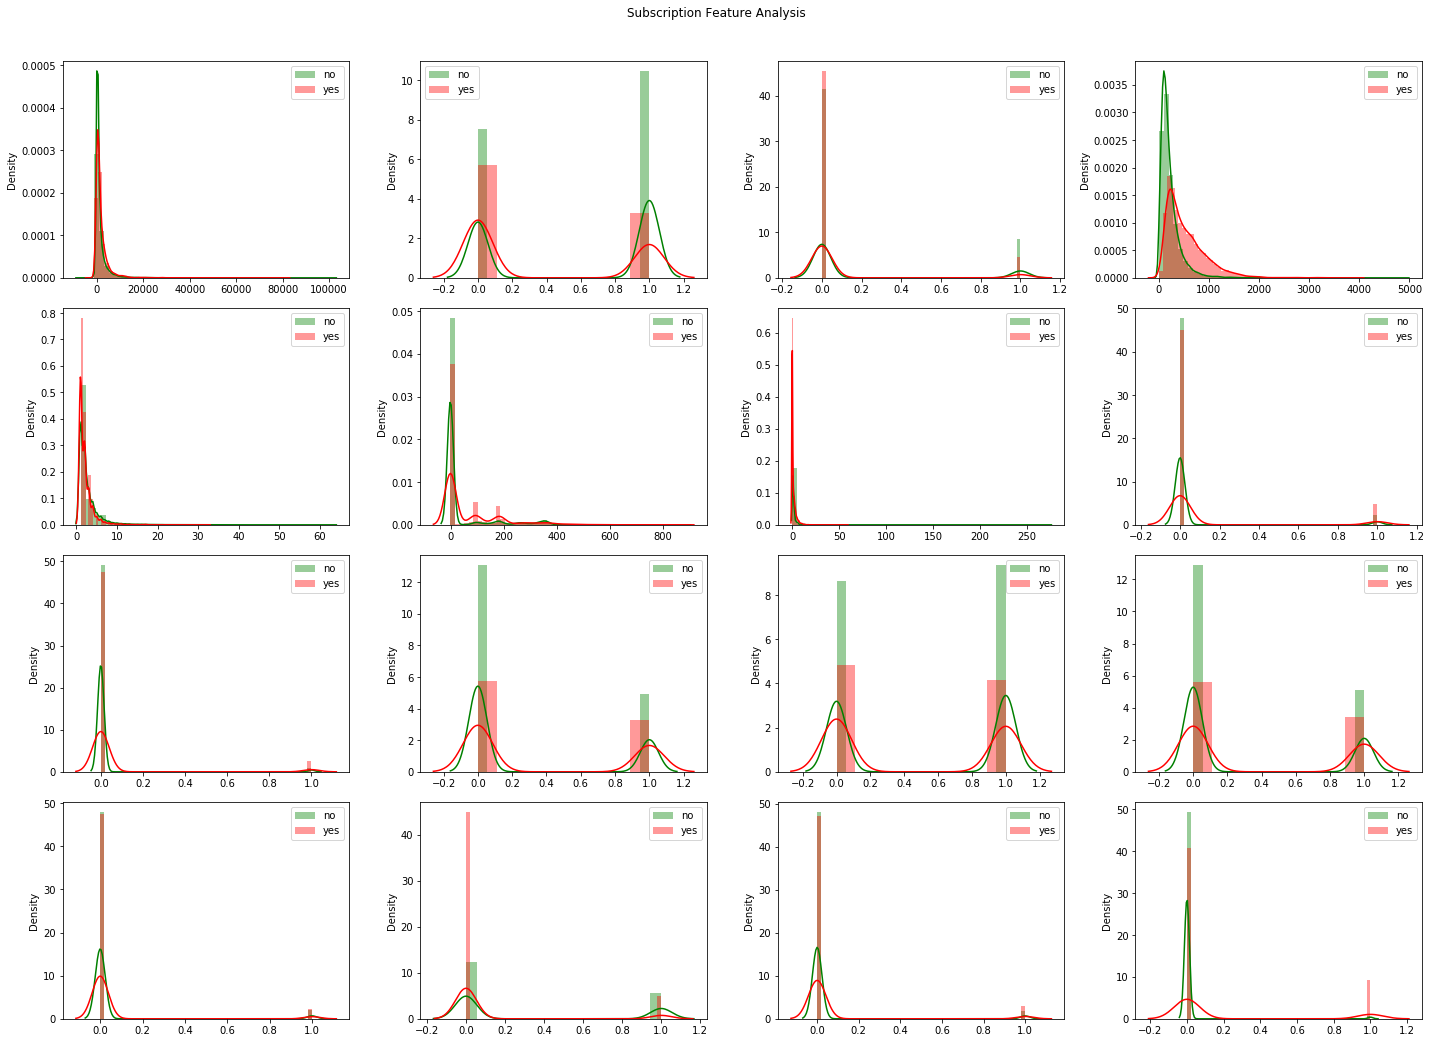

In [100]:
# Visualize the selected features
fig = plt.figure(figsize = (20, 25))
j = 0
for i in data_red.columns:
    plt.subplot(7, 4, j+1)
    j += 1
    sns.distplot(data_red[i][y==0].values, color='g', label='no')
    sns.distplot(data_red[i][y==1].values, color='r', label='yes')
    plt.legend(loc='best')
fig.suptitle('Subscription Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

### Exercise: Cross-validated LASSO feature importance

In [107]:
### START CODE HERE ###
# Instantiate the cross-validated LASSO regressor
reg = LassoCV()
# Train the regressor on the reduced df
reg.fit(X=data_red.to_numpy(), y=y)
### END CODE HERE ###
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" % reg.score(data_red, y))
coef = pd.Series(reg.coef_, index = data_red.columns)
print(f"Lasso picked {sum(coef != 0)} features and eliminated the other {sum(coef == 0)} features")

Best alpha using built-in LassoCV: 5.170680
Best score using built-in LassoCV: 0.153695
Lasso picked 2 features and eliminated the other 14 features


### Visualize the LASSO feature importances

Text(0.5, 1.0, 'Feature importance using Lasso Model')

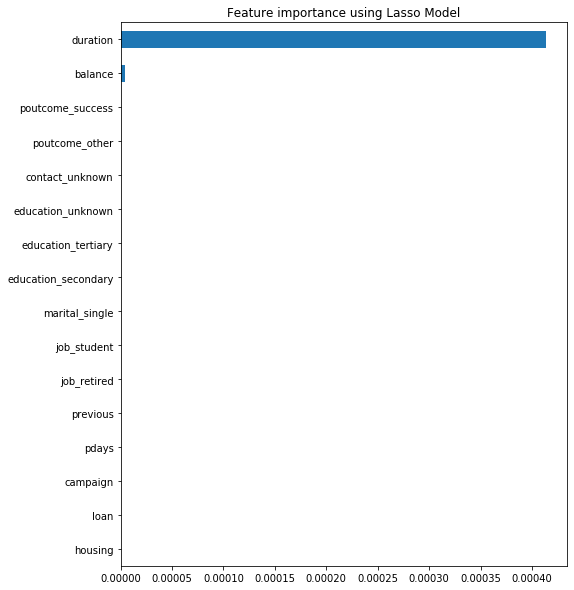

In [108]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")
#pdays is the only other feature here

### Print summary statistics for the reduced df

In [109]:
data_red.describe()

,balance,housing,loan,duration,campaign,pdays,previous,job_retired,job_student,marital_single,education_secondary,education_tertiary,education_unknown,contact_unknown,poutcome_other,poutcome_success
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,1362.272058,0.555838,0.160226,258.163080,2.763841,40.197828,0.580323,0.050076,0.020747,0.282896,0.513194,0.294198,0.041074,0.287983,0.040698,0.033421
std,3044.765829,0.496878,0.366820,257.527812,3.098021,100.128746,2.303441,0.218105,0.142538,0.450411,0.499831,0.455687,0.198464,0.452828,0.197592,0.179735
min,-8019.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,72.000000,0.000000,0.000000,103.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,448.000000,1.000000,0.000000,180.000000,2.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1428.000000,1.000000,0.000000,319.000000,3.000000,-1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,102127.000000,1.000000,1.000000,4918.000000,63.000000,871.000000,275.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Random Forest Classification

### First, import some convenience functions and perform a 70-30 train-test split split on the (reduced) training data

In [110]:
from sklearn.model_selection import cross_val_score
from numpy import mean
x_train, x_test, y_train, y_test = train_test_split(data_red.values, y.values, test_size = 0.3)

### Exercise: Default Random Forest Classifier, without balancing

In [111]:
### START CODE HERE ###
# Instantiate the classifier
# Set the max depth to 10 and the random state to 0
clf = RandomForestClassifier(max_depth=10, random_state=0)
# Train the classifier
clf.fit(x_train, y_train)
# Use the classifier to make predictions from the test features
prediction = clf.predict(x_test)
# Compute the confusion matrix between the true and predicted test targets
cm = confusion_matrix(y_test, prediction)
# Compute the model's accuracy by summing the diagonals of the confusion matrix
# (i.e. taking its trace) and dividing by the number of test samples
accuracy = (cm[0][0] + cm[1][1]) / y_test.shape[0]
### END CODE HERE ###
print(f"Accuracy = {accuracy}")
recall_scores = cross_val_score(clf, x_test, y_test, scoring='recall', cv=5)
f1_scores = cross_val_score(clf, x_test, y_test, scoring='f1', cv=5)
print(f'Mean Recall = {mean(recall_scores):.3f}')
print(f'Mean F1 Score = {mean(f1_scores):.3f}')
print(cm)

Accuracy = 0.9020200530816869
Mean Recall = 0.352
Mean F1 Score = 0.460
[[11746   201]
 [ 1128   489]]


### Exercise: Random Forest Classifier with weight balancing

The target class is highly imbalanced; recall from earlier that only about 11.7% of loan applicants in this dataset are approved. One way around this is to add weight balancing to the classifier.

This exercise is otherwise a repeat of the previous one.

In [112]:
### START CODE HERE ###
# Instantiate the classifier
# Set the max depth to 10, the random state to 0, and the class_weight to 'balanced'
clf = RandomForestClassifier(max_depth=10, random_state=0, class_weight='balanced')
# Train the classifier
clf.fit(x_train, y_train)
# Use the classifier to make predictions from the test features
prediction = clf.predict(x_test)
# Compute the confusion matrix between the true and predicted test targets
cm = confusion_matrix(y_test, prediction)
# Compute the model's accuracy by summing the diagonals of the confusion matrix
# (i.e. taking its trace) and dividing by the number of test samples
accuracy = (cm[0][0] + cm[1][1]) / y_test.shape[0]
### END CODE HERE ###
print(f"Accuracy = {accuracy}")
recall_scores = cross_val_score(clf, x_test, y_test, scoring='recall', cv=5)
f1_scores = cross_val_score(clf, x_test, y_test, scoring='f1', cv=5)
print(f'Mean Recall = {mean(recall_scores):.3f}')
print(f'Mean F1 Score = {mean(f1_scores):.3f}')
print(cm)

Accuracy = 0.8324240636980241
Mean Recall = 0.759
Mean F1 Score = 0.537
[[9974 1973]
 [ 300 1317]]
